# OHW 2021 - Model Subsampling Project

## OceanHackWeek21 project to subsample high-resolution model output as if by gliders, ships, or other *in situ* platforms

The goal of this project is to create a Python package that takes an input trajectory (e.g., the path of an ocean glider or a ship-based underway CTD), subsamples output from a high-resolution ocean simulation along that trajectory, and returns a set of subsampled variables (e.g., standard physical variables temperature, salinity, velocity; derived physical quantities such as steric height; biogeochemical quantities if available). We envision this package having two potential uses: 1) designing in situ sampling strategies, and 2) interpreting in situ data in the context of a highly resolved oceanographic model.

In [1]:
## Imports

# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Third-party packages for data interpolation
from scipy import interpolate

# Third-party packages for data visualizations
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline

### Import model data

We chose to subsample [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=): the 4x4 degree regiononal domains are small enough to enable fairly easy downloads and processing. The data from the model were retrieved using the first section of [`Pre-SWOT_Numerical_Simulation_Demo.ipynb`](https://github.com/podaac/tutorials/blob/master/notebooks/Pre-SWOT_Numerical_Simulation_Demo.ipynb) (everything before the "Plot eight 2D fields" heading) and saved as `LLC4320_pre-SWOT_ACC_SMST_20111221.nc`. 

In [2]:
## Load model data
ndays = 3 # number of days to load
target_files = [f"LLC4320_pre-SWOT_ACC_SMST_201112{day}.nc" for day in range(21,21+3)] # list target files
# Load all netCDF files
ds = xr.open_mfdataset(target_files)

In [3]:
# Change coordinate of time to make life easier
ds = ds.assign_coords(time=np.linspace(0,ds.time.size-1, num=ds.time.size))

LLC4320 data does not have lat, lon as coordinates; instead the coordinates are simply index numbers. This means that the lon-lat-depth passed for the trajectory will have to be converted to the corresponding index numbers.

In [4]:
## Convert lon, lat and z to index i, j and k with f_x, f_y and f_z
X = ds.XC.isel(time=0) # XC, YC and Z are the same at all times, so select a single tim
Y = ds.YC.isel(time=0)
i = ds.i
j = ds.j
z = ds.Z.isel(time=0)
k = ds.k

f_x = interpolate.interp1d(X[0,:].values, i)
f_y = interpolate.interp1d(Y[:,0].values, j)
f_z = interpolate.interp1d(z, k, bounds_error=False)

## Select sampling strategy

Use the SAMPLING_STRATEGY variable to select whether you want to sample the model using a real glider track ('real_glider'), a simulated glider track ('sim_glider') or a simulated underway ctd ('sim_uctd')

In [5]:
SAMPLING_STRATEGY = 'real_glider' 

### If you would like to subsample the model using a real glider track, set `SAMPLING_STRATEGY = 'real_glider'` and the following cells will be run.

Our example glider track original came from [this repo](https://github.com/earthcube2021/ec21_balwada_etal). It wasn't inside one of the regions covered by LLC4320. Here, we load the trajectory and transpose it such that it fits within the Southern Ocean region.

In [6]:
if SAMPLING_STRATEGY == 'real_glider':
    ## Load and transpose glider data

    # Load data
    ds_CTD_659 = xr.load_dataset('CTD_659.nc')

    # Print glider boundaries
    s = 'Original glider boundaries:\nNorth: {n}\nSouth: {s}\nEast: {e}\nWest: {w}\n'.format(
        n=ds_CTD_659.latitude.data.max(),
        s=ds_CTD_659.latitude.data.min(),
        e=ds_CTD_659.longitude.data.max(),
        w=ds_CTD_659.longitude.data.min()
    )
    print(s)

    # Get boundaries of model region
    model_boundary_n = ds.YC.max()
    model_boundary_s = ds.YC.min()
    model_boundary_w = ds.XC.min()
    model_boundary_e = ds.XC.max()

    # Print model boundaries
    s = 'Model boundaries:\nNorth: {n}\nSouth: {s}\nEast: {e}\nWest: {w}\n'.format(
        n=model_boundary_n.data,
        s=model_boundary_s.data,
        e=model_boundary_e.data,
        w=model_boundary_w.data
    )
    print(s)

    # Transpose latitude
    shifted_lat = (ds_CTD_659.latitude - ds_CTD_659.latitude.min()
                  )/(ds_CTD_659.latitude.max() - ds_CTD_659.latitude.min()
                    )*(model_boundary_n-model_boundary_s)+ model_boundary_s


    # Transpose longitude
    shifted_lon = (ds_CTD_659.longitude - ds_CTD_659.longitude.min()
                  )/(ds_CTD_659.longitude.max() - ds_CTD_659.longitude.min()
                    )*(model_boundary_e-model_boundary_w)+ model_boundary_w

    # Print transposed glider boundaries
    s = 'Transposed glider boundaries:\nNorth: {n}\nSouth: {s}\nEast: {e}\nWest: {w}\n'.format(
        n=shifted_lat.max().data,
        s=shifted_lat.min().data,
        e=shifted_lon.max().data,
        w=shifted_lon.min().data
    )
    print(s)
    
    
    ## Assemble trajectory dataset

    # Remove NaN values from pressure (depth) data
    depth = -ds_CTD_659.pressure.where(~np.isnan(ds_CTD_659.pressure), drop=True)
    n = len(depth)

    ## Assemble dataset
    # real (lat/lon) coordinates
    survey_realcoords = xr.Dataset(
        dict(
            lon = xr.DataArray(shifted_lon.where(~np.isnan(ds_CTD_659.pressure), drop=True),dims='points'),
            lat = xr.DataArray(shifted_lat.where(~np.isnan(ds_CTD_659.pressure), drop=True),dims='points'),
            dep = xr.DataArray(depth,dims='points'),
            time = xr.DataArray(np.linspace(ds.time[0], ds.time[-1]/24, num=n),dims='points') # convert time from # of hourly steps to days 
        )
    )
    
    # transform to i,j,k coordinates:
    survey_track= xr.Dataset(
        dict(
            i = xr.DataArray(f_x(survey_realcoords.lon), dims='points'),
            j = xr.DataArray(f_y(survey_realcoords.lat), dims='points'),
            k = xr.DataArray(f_z(survey_realcoords.dep), dims='points'),
            time = xr.DataArray(survey_realcoords.time,dims='points')
        )
    )

Original glider boundaries:
North: -50.363265
South: -53.458083333333335
East: 38.99485
West: 30.026965

Model boundaries:
North: dask.array<nanmax-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
South: dask.array<nanmin-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
East: dask.array<nanmax-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
West: dask.array<nanmin-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

Transposed glider boundaries:
North: dask.array<nanmax-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
South: dask.array<nanmin-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
East: dask.array<nanmax-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
West: dask.array<nanmin-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>



### If you would like to subsample the model using a simulated glider or ship-based uCTD track, set `SAMPLING_STRATEGY = 'sim_glider'` or `'sim_uctd'` and the following cells will be run.

In [7]:
if SAMPLING_STRATEGY == 'sim_glider' or SAMPLING_STRATEGY == 'sim_uctd':
    # code originally from make_trajectory.ipnyb
    # --------- define sampling: change the values in this section -------
    PATTERN = 'lawnmower' # back-forth or lawnmower ... could add others
    survey_time_total = ndays * 86400 # if non-zero, limits the survey to a total time


    # typical speeds and depth ranges based on platform 
    if SAMPLING_TYPE == 'sim_uctd':
        # typical values for uctd sampling:
        zrange = [-5, -500] # depth range of profiles (down is negative)
        hspeed = 5 # platform horizontal speed in m/s
        vspeed = 1 # platform vertical (profile) speed in m/s (NOTE: may want different up/down speeds)

    elif SAMPLING_TYPE == 'sim_glider':
        # typical values for glider sampling:
        zrange = [-1, -1000] # depth range of profiles (down is negative)
        hspeed = 0.25 # platform horizontal speed in m/s
        vspeed = 0.25 # platform vertical (profile) speed in m/s  (NOTE: is this typical?)

    # define x & y waypoints and z range
    # - these are for the ACC_SMST region specifically ... could make generic based on the lat/lon of the domain
    # xwaypoints & ywaypoints must have the same size
    if PATTERN == 'lawnmower':
        # "mow the lawn" pattern - define all waypoints
        xwaypoints = [151, 151, 151.5, 151.5, 152, 152, 152.5, 152.5]
        ywaypoints = [-56, -55,   -55,   -56, -56, -55, -55, -56] 
    elif PATTERN == 'back-forth':
        # repeated back & forth transects - define the end-points
        xwaypoints = [151, 152]
        ywaypoints = [-56, -55]
        # repeat waypoints based on # of transects: 
        dkm_per_transect = great_circle(xwaypoints[0], ywaypoints[0], xwaypoints[1], ywaypoints[1]) # distance of one transect in km
        t_per_transect = dkm_per_transect * 1000 / hspeed # time per transect, seconds
        num_transects = np.round(sample_time_total / t_per_transect)
        for n in np.arange(num_transects):
            xwaypoints = np.append(xwaypoints, xwaypoints[-2])
            ywaypoints = np.append(ywaypoints, ywaypoints[-2])

    # time resolution of sampling (dt):
    # use the time between vertical measurements
    # for now, use a constant  vertical resolution (can change this later)
    zresolution = 10 # meters
    zprofile = np.arange(zrange[0],zrange[1],-zresolution) # depths for one profile
    ztwoway = np.append(zprofile,zprofile[-1:0:-1])

    dt = zresolution / vspeed # sampling resolution in seconds
    # for each timestep dt 
    deltah = hspeed*dt # horizontal distance traveled per sample
    deltav = vspeed*dt # vertical distance traveled per sample


    # determine the sampling locations in 2-d space
    # - initialize sample locations xs, ys, zs, ts
    xs = []
    ys = []
    zs = []
    ts = []
    dkm_total = 0 
    # great circle distance (from Jake Steinberg) (move this to the top?)
    from math import radians, degrees, sin, cos, asin, acos, sqrt
    def great_circle(lon1, lat1, lon2, lat2):
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))

    for w in np.arange(len(xwaypoints)-1):
        # interpolate between this and the following waypoint:
        dkm = great_circle(xwaypoints[w], ywaypoints[w], xwaypoints[w+1], ywaypoints[w+1])
        # number of time steps (vertical measurements) between this and the next waypoint
        nstep = int(dkm*1000 / deltah) 
        yi = np.linspace(ywaypoints[w], ywaypoints[w+1], nstep)
        xi = np.linspace(xwaypoints[w], xwaypoints[w+1], nstep)
        xi = xi[0:-1] # remove last point, which is the next waypoint
        xs = np.append(xs, xi) # append
        yi = yi[0:-1] # remove last point, which is the next waypoint
        ys = np.append(ys, yi) # append
        dkm_total = dkm_total + dkm
        t_total = dkm_total * 1000 / hspeed
        # cut off the survey after survey_time_total, if specified
        if survey_time_total > 0 and t_total > survey_time_total:
            break

    # depths: repeat (tile) the two-way sampling depths (NOTE: for UCTD sampling, often only use down-cast data)
    # how many profiles do we make during the survey?
    n_profiles = np.ceil(xs.size / ztwoway.size)
    zs = np.tile(ztwoway, int(n_profiles))
    zs = zs[0:xs.size]
    # sample times: (units are in seconds since zero => convert to days, to agree with ds.time)
    ts = dt * np.arange(xs.size) / 86400 
    
    ## Assemble dataset:
    # real (lat/lon) coordinates
    survey_realcoords = xr.Dataset(
        dict(
            lon = xr.DataArray(xs,dims='points'),
            lat = xr.DataArray(ys,dims='points'),
            dep = xr.DataArray(zs,dims='points'),
            time = xr.DataArray(ts,dims='points')
        )
    )
    # transform to i,j,k coordinates:
    survey_track= xr.Dataset(
    dict(
        i = xr.DataArray(f_x(survey_realcoords.lon), dims='points'),
        j = xr.DataArray(f_y(survey_realcoords.lat), dims='points'),
        k = xr.DataArray(f_z(survey_realcoords.dep), dims='points'),
        time = xr.DataArray(survey_realcoords.time,dims='points'),
    )
)

### Perform the interpolation

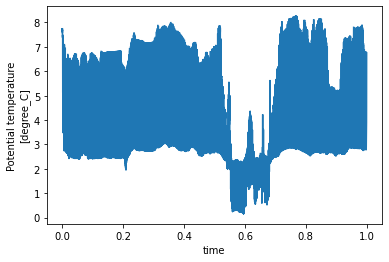

In [8]:
# create a new dataset to contain the interpolated data
subsampled_data = xr.Dataset() # NOTE: add more metadata to this dataset?
subsampled_data['Theta']=ds.Theta.interp(survey_track) # NOTE: is there a smarter way to do this using variable names and a loop?
subsampled_data['Salt']=ds.Theta.interp(survey_track) # NOTE: is there a smarter way to do this using variable names:
subsampled_data['lon']=survey_realcoords.lon
subsampled_data['lat']=survey_realcoords.lat
subsampled_data['dep']=survey_realcoords.dep
subsampled_data['time']=survey_realcoords.time
subsampled_data
# test plot
subsampled_data.Theta.plot(x='time') 